# 💻 Overlay

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GMGI221-2024/forelesninger/blob/main/08_overlay.ipynb)

Overlay-analyser er GIS-operasjoner der to eller flere vektorlag er
kombinert for å produsere nye geometrier. Typiske overlay-operasjoner inkluderer *union*,
*intersection*, og *difference* - navngitt etter resultatet av kombinasjonen av to lag.


![Fire paneler som viser union, intersection, symmetric difference og difference av to geometrier.](imgs/overlay_operations.png)


Romlig overlay med to inputvektorlag (rektangel, sirkel). Det resulterende vektorlaget vises i grønt. *Kilde: [QGIS dokumentasjon](https://docs.qgis.org/latest/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html#figure-overlay-operations)*
:::


I denne notebooken vil vi utføre en overlay-analyse for å velge de polygon-cellene i et grid-datasett som ligger innenfor Oslo. I denne
øvelsen, bruker vi to input-datasett: et grid av statistiske polygoner med
befolkningen i Oslo og et polygon-datasett av norske kommuner
(`kommuner.gpkg`), hvor vi skal velge bare Oslo kommune.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

In [2]:
import geopandas

rutenett = geopandas.read_file(DATA_MAPPE / "ssb_rutenett" / "befolkning_250m_2023_akershus.gpkg")


kommuner = geopandas.read_file(
    DATA_MAPPE / "kommuner" / "kommuner.gpkg"
)
display(kommuner.head())

,gml_id,lokalId,navnerom,versjonId,oppdateringsdato,gyldigFra,datauttaksdato,navn,språk,kommunenummer,kommunenavn,samiskForvaltningsområde,geometry
0,kommune.1,0466e7c3-6a23-4b70-97d4-cf81f949490b,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T17:47:39,2024-01-01,2024-03-04T12:27:57,Ibestad,nor,5514,Ibestad,False,"MULTIPOLYGON (((589669.263 7630312.979, 589669..."
1,kommune.2,0f821a2d-a307-41ec-9b64-f01c80e39357,https://data.geonorge.no/sosi/inndelinger/innd...,4,2023-11-07T23:33:28,2023-11-07,2024-03-04T12:27:57,Rendalen,nor,3424,Rendalen,False,"MULTIPOLYGON (((327391.890 6869419.570, 327363..."
2,kommune.3,251a3fdd-ac96-4ef2-badb-a9b75e6ab2e6,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T15:42:05,2024-01-01,2024-03-04T12:27:57,Rakkestad,nor,3120,Rakkestad,False,"MULTIPOLYGON (((284560.990 6591094.550, 284575..."
3,kommune.4,2758a7b8-edba-4d6a-936e-4754ce03ca8f,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T15:56:10,2024-01-01,2024-03-04T12:27:57,Nordre Follo,nor,3207,Nordre Follo,False,"MULTIPOLYGON (((269615.270 6638265.470, 269615..."
4,kommune.5,340fff7f-b153-4a87-814d-12ca4f2d1682,https://data.geonorge.no/sosi/inndelinger/innd...,4,2023-11-07T23:33:28,2023-11-07,2024-03-04T12:27:57,Overhalla,nor,5047,Overhalla,False,"MULTIPOLYGON (((359415.100 7152572.930, 359412..."


Vi kan nå velge bare Ås kommune fra kommune-datasettet.

In [3]:
aas = kommuner.loc[kommuner["navn"] == "Ås"]
aas.head()

,gml_id,lokalId,navnerom,versjonId,oppdateringsdato,gyldigFra,datauttaksdato,navn,språk,kommunenummer,kommunenavn,samiskForvaltningsområde,geometry
27,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T16:00:22,2024-01-01,2024-03-04T12:27:57,Ås,nor,3218,Ås,False,"MULTIPOLYGON (((266871.580 6614231.500, 266871..."


Før vi fortsetter er det en god ide å sørge for at begge lagene har samme koordinatsystem:

In [4]:
# Sjekke at lagene har samme crs
rutenett.crs == aas.crs

False

De er ikke i samme koordinatsystem, så vi må transformere ett av lagene, sånn som vi gjorde i [en tidligere uke](#04_projeksjoner):

In [5]:
# Transformere Ås-geodataframen
rutenett = rutenett.to_crs(aas.crs)
# Sjekke at lagene har samme crs
rutenett.crs == aas.crs

True

La oss gjøre en rask overleggsvisualisering av de to lagene:

<Axes: >

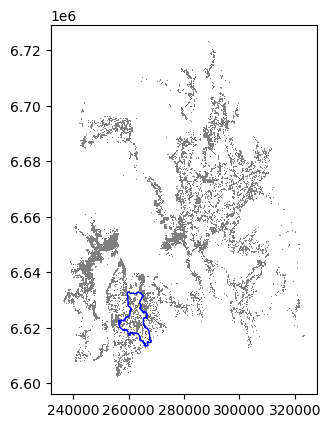

In [6]:
# Plott lagene
ax = rutenett.plot(color="gray")
aas.plot(ax=ax, facecolor="None", edgecolor="blue")

Her er alle de grå rutene gridceller med befolkningsdata for Akershus fylke. Datasettet inneholder 17376 ruter.
Det blå omrisset representerer Ås kommune. Vårt mål er nå å utføre en overlay-analyse og velge de geometriene fra rutenettet som krysser polygonet for Ås kommune.

Vi vil lage et nytt lag basert på rutenett-polygoner som `intersect`-er med Ås-laget vårt. Vi kan bruke metoden `overlay()` med en `GeoDataFrame` for å utføre overlay-analysen som tar som en input 1) andre GeoDataFrames, og 2)
parameteren `how` som kan brukes til å kontrollere hvordan overlay-analysen blir
utført (mulige verdier er `'intersection'`, `'union'`,`'symmetric_difference'`, `'difference'`, og `'identity'`):

In [7]:
intersection = rutenett.overlay(aas, how="intersection")

La oss plotte dataene våre og se hva vi har:

<Axes: >

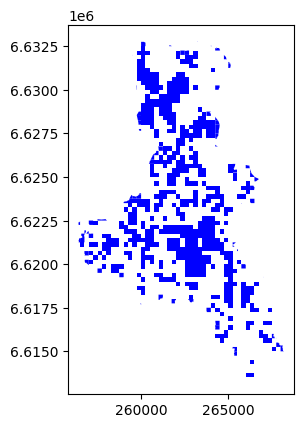

In [8]:
intersection.plot(color="b")

Som et resultat har vi nå bare de rutenett cellene som krysser med Helsingfors
grenser. Hvis du ser nøye etter, kan du også observere at **rutenett cellene er
klippet basert på grensen.**

- Hva med dataattributter? La oss se hva vi har:

In [9]:
intersection.head()

,ru250m,pop_tot,gml_id,lokalId,navnerom,versjonId,oppdateringsdato,gyldigFra,datauttaksdato,navn,språk,kommunenummer,kommunenavn,samiskForvaltningsområde,geometry
0,22605006625250,10,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T16:00:22,2024-01-01,2024-03-04T12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((260500.000 6625250.000, 260500.000 6..."
1,22617506625250,3,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T16:00:22,2024-01-01,2024-03-04T12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((261750.000 6625250.000, 261750.000 6..."
2,22620006625250,23,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T16:00:22,2024-01-01,2024-03-04T12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((262000.000 6625250.000, 262000.000 6..."
3,22622506625250,10,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T16:00:22,2024-01-01,2024-03-04T12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((262250.000 6625250.000, 262250.000 6..."
4,22625006625250,14,kommune.28,d285e9c4-8da0-4dfc-b927-31ba7ee17e6a,https://data.geonorge.no/sosi/inndelinger/innd...,3,2023-11-28T16:00:22,2024-01-01,2024-03-04T12:27:57,Ås,nor,3218,Ås,False,"POLYGON ((262500.000 6625250.000, 262500.000 6..."


Som vi kan se, på grunn av overleggsanalysen, inneholder datasettet attributtene
fra begge input lagene.

La oss lagre resultatrutenettet vårt som en GeoPackage.

In [10]:
intersection.to_file(
    DATA_MAPPE / "intersection.gpkg",
    layer="befolkning_aas_kommune"
)

Det er mange flere eksempler på forskjellige typer overleggsanalyse i
[Geopandas dokumentasjon](http://geopandas.org/set_operations.html) hvor du
kan gå og lære mer.